# The spelled-out intro to neural networks and backpropagation: building micrograd

This notebook is a re-implementation of the micrograd Autograd engine and a basic MLP module introduced in Andrej Karpathy's [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1) as part of the Neural Networks: Zero to Hero series.

## Micrograd
Micrograd is a scalar-valued Autograd engine, meaning it can only handle scalars. We create a `Value` class to hold the scalar values and provide the autograd functionality.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0 # self.grad maintains the derivative of L with respect to this value
        self._backward = lambda: None # self._backward stores how to compute gradients for the node's children and chain it with self.grad
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                # add all children before adding self
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad += 1.0 # base case for backprop
        for node in reversed(topo):
            node._backward()
    
    # Define overrides for operations
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other,), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # need this to handle number * Value operations (rather than Value * number) 
        return self * other
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * other**-1
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        e = (2 * self).exp()
        return (e - 1) / (e + 1)

A few things to note about the `Value` class:
1. In the `backward` method, we first perform a topological sort on the nodes before calling `_backward` on the individual nodes. This is because to call `_backward` on a node, we need to have computed the derivatives of its parents to apply the Chain Rule. The topological sort guarantees that the required derivatices are available when we need them.
2. `self._backward` stores how to compute gradients for the node's children and chain it with self.grad. In the `_backward` function for each operation, we have a pattern of [local derivative] * [parent's derivative], where the multiplication of the parent's derivative comes from an application of the Chain Rule.
3. In `self._backward`, we accumulate the gradient (+=) instead of assigning in order to avoid a bug when the same node is used multiple times.
4. We can technically define operations to any arbitrary level of composition, e.g. we could define a `tanh` function directly, or build it up from basic arithmetic operations using the formula $tanh(x) = (e^{2x} - 1) / (e^{2x}+1)$, as long as we can define the forward and backward pass for it.

We can test that the `Value` class correctly handles various types of operations.

In [3]:
a = Value(2.0)
b = Value(4.0)
print(f"a+b={a + b}")
print(f"a/b={a / b}")
print(f"a**3={a ** 3}")

a+b=Value(data=6.0)
a/b=Value(data=0.5)
a**3=Value(data=8.0)


We can also test the autograd functionality of our `Value` class. We will first set up some code to visualize the dependency graph and then run a forward-backward pass on a simple example.

In [4]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build (v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [5]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.8813735870195432, label='b') # this arbitrary value just makes the results nicer numbers

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()

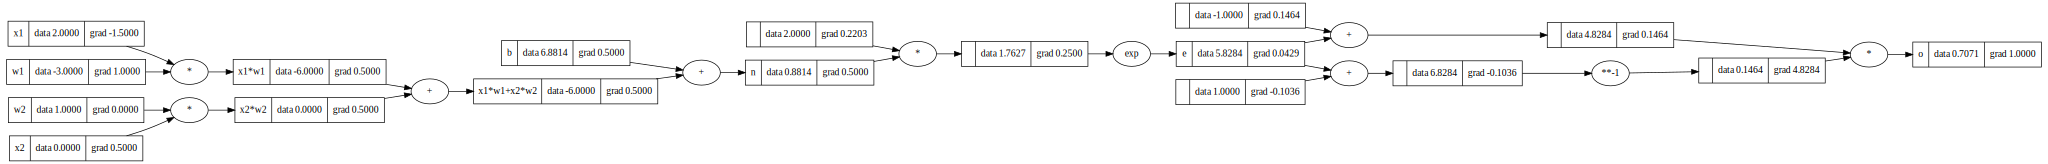

In [6]:
draw_dot(o)

## MLP module
Now we have an autograd engine for scalars. Next, we will build a neural network module resembling the PyTorch style.

In [7]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs if len(outs) > 1 else outs[0]
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        

class MLP:
    
    def __init__(self, nin, nouts):
        # nouts is a list of the sizes of each layer in order
        sz = [nin] + nouts
        # take pairs of consecutive layers to find appropriate input and output dimensions
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    
def mse_loss(targets, preds):
    return sum([(pred - target) ** 2 for target, pred in zip(targets, preds)])

A `MLP` (Multi-Layer Perceptron) consists of `Layer`s which consist of `Neuron`s. Each `Neuron` is simply a set of weights and a bias that are initialized randomly, and its forward pass computes the activation. A `Layer` is a group of independent `Neuron`s.

When we pass an input through the MLP, we get a prediction as an output. We can use a loss function (mean squared error in this case) to measure how far our predictions are from the targets.

Let's see an example on a small neural network with 3-dimensional inputs, two 4-dimensional hidden layers, and a final scalar value output. 

In [8]:
myMLP = MLP(3, [4,4,1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [9]:
# training loop
for k in range(30):
    # forward pass
    ypred = [myMLP(x) for x in xs]
    loss = mse_loss(ys, ypred)
    
    # backward pass
    for p in myMLP.parameters():
        # zero out gradients from previous pass before computing fresh values
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in myMLP.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 6.898993632470425
1 5.520640402212945
2 4.148399058336544
3 2.7960596195248635
4 2.207306199177304
5 1.7938614458450894
6 1.4090407570630226
7 1.0807568090706696
8 0.8271972084659731
9 0.6417227001500538
10 0.5066704263406607
11 0.4070487099844735
12 0.33235514333511895
13 0.27546360467984055
14 0.2315039866287824
15 0.1970790452437926
16 0.16977475053813101
17 0.14785081179219697
18 0.1300381328449501
19 0.11540184506910244
20 0.10324659091749216
21 0.09305012054727867
22 0.08441632303864385
23 0.07704177227122763
24 0.07069173995491283
25 0.0651828757072099
26 0.060370606321068665
27 0.05613989446677919
28 0.052398404251393284
29 0.04907140341229053


In [10]:
ypred

[Value(data=0.9583931918436509),
 Value(data=-0.8482563831952816),
 Value(data=-0.8884430038287936),
 Value(data=0.8910541956218069)]

We can see that the loss decreases nicely during the training loop, and the final `ypred` values we get are similar to the targets of `[1.0, -1.0, -1.0, 1.0]`. This is a nice sanity check to see that our micrograd engine and MLP modules are working as intended!